# Species assignment of mosquitoes undetermined by PCR
Notebook adapted from Batson, *et al.* (https://github.com/czbiohub/california-mosquito-study).

In [1]:
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as shc
import matplotlib.patches as mpatches
from sklearn.cluster import AgglomerativeClustering
from collections import namedtuple
from numpy import nan
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score

In [4]:
new_metadata = pd.read_csv(
    "data/BEmosq_metadata.csv",
    header=0,
    sep=";"
)
new_metadata

,Sample,PCR_Subspecies,SKA_Subspecies,Species,Sex,Location,Control,visual_genus,visual_species,lat,long,Municipality
0,MEMO001,Culex pipiens pipiens,Culex pipiens pipiens,Culex pipiens,female,MM,No,Culex,pipiens pipiens,50.995.194,5.621.833,Maasmechelen
1,MEMO002,Culex pipiens pipiens,Culex pipiens pipiens,Culex pipiens,female,MM,No,Culex,pipiens pipiens,50.995.194,5.621.833,Maasmechelen
2,MEMO003,Culex pipiens pipiens,Culex pipiens pipiens,Culex pipiens,female,MM,No,Culex,pipiens pipiens,50.995.194,5.621.833,Maasmechelen
3,MEMO004,Culex torrentium,Culex torrentium,Culex torrentium,female,MM,No,Culex,torrentium,50.995.194,5.621.833,Maasmechelen
4,MEMO005,Culex pipiens pipiens,Culex pipiens pipiens,Culex pipiens,female,MM,No,Culex,pipiens pipiens,50.995.194,5.621.833,Maasmechelen
...,...,...,...,...,...,...,...,...,...,...,...,...
203,MEMO020-NC,control,control,control,control,control,Yes,NaN,NaN,NaN,NaN,NaN
204,MEMO046-NC,control,control,control,control,control,Yes,NaN,NaN,NaN,NaN,NaN
205,MEMO076-NC,control,control,control,control,control,Yes,NaN,NaN,NaN,NaN,NaN
206,MEMO114-NC,control,control,control,control,control,Yes,NaN,NaN,NaN,NaN,NaN


In [5]:
species_id = new_metadata[[
    "Sample",
    "visual_genus",
    "visual_species",
    "Municipality"
]]

species_id.set_index("Sample", inplace=True)
species_id.dropna(how='all', inplace= True)
species_id

<ipython-input-5-e5a99af1c840>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_id.dropna(how='all', inplace= True)


,visual_genus,visual_species,Municipality
Sample,,,
MEMO001,Culex,pipiens pipiens,Maasmechelen
MEMO002,Culex,pipiens pipiens,Maasmechelen
MEMO003,Culex,pipiens pipiens,Maasmechelen
MEMO004,Culex,torrentium,Maasmechelen
MEMO005,Culex,pipiens pipiens,Maasmechelen
...,...,...,...
NEMO50,Culex,pipiens pipiens,Bertem
NEMO51,Culex,pipiens pipiens,Bertem
NEMO52,Culex,pipiens pipiens,Bertem


In [20]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colorbar

def clean_data(dd_tsv, metadata):
    '''
    remove trailing suffix and replace column name spaces with underscores
    '''
    
    dd_tsv.columns = dd_tsv.columns.str.replace(" ", "_")

    # Add prefix columns and size
    dd_tsv["Sample_1"] = dd_tsv.apply(
        lambda row: row["Sample_1"],
        axis=1
    )
    dd_tsv["Sample_2"] = dd_tsv.apply(
        lambda row: row["Sample_2"],
        axis=1
    )

    # re-organize columns
    dd_tsv = dd_tsv[
        [
            "Sample_1",
            "Sample_2",
            "Matches",
            "Mismatches",
            "Jaccard_Index",
            "Mash-like_distance",
            "SNPs",
            "SNP_distance"
        ]
    ]
    
    # Add row to keep last sample
    uniques_sample_2 = [
    y
    for y in dd_tsv["Sample_2"].unique()
    ]
    
    last_sample = uniques_sample_2[-1]
    
    last_row = {
        "Sample_1":last_sample, 
        "Sample_2":last_sample, 
        "Matches":0, 
        "Mismatches":0, 
        "Jaccard_Index":0, 
        "Mash-like_distance":0, 
        "SNPs":0, 
        "SNP_distance":0
    }
    
    dd_tsv=dd_tsv.append(last_row, ignore_index=True)
    return dd_tsv


def create_pivot(df, values="SNP_distance", diagonal=0, remove_water=False):
    ''' create pivot tables with sample 1 and sample 2 correlations'''

    dd_tsv_pivot = df.pivot(
        columns="Sample_1",
        index="Sample_2",
        values=values
    )
    dd_tsv_pivot = dd_tsv_pivot.reindex(dd_tsv_pivot.columns)
    np.fill_diagonal(dd_tsv_pivot.values, diagonal)
    dd_tsv_pivot = dd_tsv_pivot.fillna(0) + dd_tsv_pivot.T.fillna(0) - np.diag(dd_tsv_pivot.values.diagonal())

    # remove waters from pivot table
    if remove_water:
        t_raw_piv_no_waters = dd_tsv_pivot[~(dd_tsv_pivot.index.str.contains("ater"))]
        t_raw_piv_no_waters_col = t_raw_piv_no_waters.drop(
            columns=t_raw_piv_no_waters.columns[
                t_raw_piv_no_waters.columns.str.contains("ater")
            ]
        )
    
        return t_raw_piv_no_waters_col
    
    else:
        return dd_tsv_pivot


def add_metadata_to_pivot(df, metadata_fields, metadata):
    """join metadata onto pivot table for axis labeling"""

    dd_tsv_pivot_w_labels = pd.merge(
        df.reset_index(),
        metadata[metadata_fields],
        how='left',
        left_on="Sample_1",
        right_index=True,
    ).reset_index().set_index(
        ["Sample_1"] + metadata_fields
    ).drop(["index"], axis=1)

    return dd_tsv_pivot_w_labels


def get_linkage(pivot_df):
    '''clustering linkage'''

    cdist = scipy.spatial.distance.squareform(pivot_df)
    return scipy.cluster.hierarchy.linkage(cdist, method="ward")


def get_cluster_map(pivot_df, linkage, num_clusters, extra=True):
    """cluster distance matrix and re-assign species as cluster species mode"""

    clusters = fcluster(linkage, num_clusters, criterion='maxclust')
    cluster_map = pd.DataFrame()
    
    if extra:
        cluster_map['Sample'] = pivot_df.index.get_level_values(0)
        #cluster_map['visual_genus'] = pivot_df['visual_genus'].tolist()
        #cluster_map['visual_species'] = pivot_df['visual_species'].tolist()
        cluster_map['visual_genus'] = pivot_df.index.get_level_values(1)
        cluster_map['visual_species'] = pivot_df.index.get_level_values(2)
        cluster_map['Municipality'] = pivot_df.index.get_level_values(3)

    cluster_map["Sample_1"] = pivot_df.columns#.drop(['visual_species', 'visual_genus'])
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)

    cluster_chunks = []
    for clust in cluster_map.cluster.unique():
        subset = cluster_map[cluster_map.cluster == clust]
        species_mode = subset.visual_species.mode()[0]
        genus_mode = subset[
            subset["visual_species"] == species_mode
        ].visual_genus.values[0]
        subset["ska_species"] = species_mode
        subset["ska_genus"] = genus_mode
        cluster_chunks.append(subset)

    cluster_map_w_ska = pd.concat(cluster_chunks)
    return cluster_map_w_ska


def join_on_ska_labels(raw_df, metadata, k, values="SNP_distance", diagonal=0):
    '''create pivot from distance matrix with old and new species labels'''

    df_cleaned = clean_data(
        raw_df,
        metadata=metadata
    )

    dd_pivot = create_pivot(
        df_cleaned,
        values=values,
        diagonal=diagonal
    )

    metadata_fields = [
        "visual_genus",
        "visual_species",
        "Municipality"
    ]

    dd_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot,
        metadata_fields,
        metadata=metadata
    )

    linkage = get_linkage(dd_pivot)

    cluster_map = get_cluster_map(
        dd_pivot_w_labels,
        linkage,
        k,
        extra=True
    )

    ska_metadata_fields = metadata_fields + ["ska_genus", "ska_species"]

    final_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot,
        ska_metadata_fields,
        metadata=cluster_map
    )

    return final_pivot_w_labels, cluster_map, linkage


def wrap_clustermap_and_mismatches(
    raw_df,
    metadata,
    k=4,
    figsize=(35, 35),
    values="SNP_distance",
    diagonal=0,
    fontsize=35,
    labelsize=25
):
    '''create clustermap with new and old species assigned labels'''

    pivot_w_labels, cluster_map, linkage = join_on_ska_labels(
        raw_df, 
        metadata, 
        k, 
        values=values, 
        diagonal=0
    )
    
    c, leg, cbar = correlation_matrix(
        pivot_w_labels,
        linkage,
        cluster_map,
        figsize=figsize,
        fontsize=fontsize,
        labelsize=labelsize
    )

    return c, leg, cbar, pivot_w_labels

def hierarchical_clustering(
    raw_df,
    metadata,
    k,
    values="SNP_distance",
    diagonal=0
):
    pivot_df, cluster_map, linkage = join_on_ska_labels(
        raw_df, 
        metadata, 
        k, 
        values=values,
        diagonal=diagonal
    )
    cdist = scipy.spatial.distance.squareform(pivot_df)
    Z = shc.linkage(cdist, method="ward")
    fig = plt.figure(figsize=(25, 10))

    dn = shc.dendrogram(
        Z,
        leaf_font_size=8,
        labels=pivot_df.index.get_level_values(4),
        color_threshold=0.008
    )

    return dn


def get_silhouette_score(
    raw_df,
    metadata,
    k,
    values="SNP_distance",
    diagonal=0,
    correlation=False
):
    '''use silhouette metric to see how compact and distinct clusters are '''
    
    pivot_df, cluster_map, linkage = join_on_ska_labels(
        raw_df, 
        metadata, 
        tailing, 
        k, 
        values=values,
        diagonal=diagonal
    )
    cdist = scipy.spatial.distance.squareform(pivot_df)
    linkage = scipy.cluster.hierarchy.linkage(cdist, method="ward")
    clusters = fcluster(linkage, k, criterion='maxclust')

    cluster_map = pd.DataFrame()

    cluster_map["Sample_1"] = pivot_df.columns.drop(['visual_species', 'visual_genus'])
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)

    return silhouette_score(
        pivot_df,
        metric="precomputed",
        labels=cluster_map["cluster"]
    )


def correlation_matrix(
    pivot_w_labels,
    linkage,
    cluster_map,
    figsize=(35, 35),
    fontsize=35,
    labelsize=25
):
    '''correlation matrix comparing visual and ska species assignment'''

    legend_labeling = {
         "Culex pipiens pipiens": "#54C568FF",#"#4c72a5",
         "Culex pipiens molestus": "#1FA188FF",#"#48a365",
         "Culex pipiens undetermined": "#FDE725FF",#"#77bedb",
         "Culex torrentium": "#BBDF27FF",#"#90ce9b",
         "Aedes japonicus": "#2A788EFF",#"#ccc197",
    }
    
    location_labeling = {
        "Bertem": "#0D0887FF",      
        "Dilsen-Stokkem": "#47039FFF",              
        "Eupen": "#7301A8FF",
        "Frameries": "#9C179EFF",
        "Kallo": "#BD3786FF",
        "Leuven": "#D8576BFF",
        "Maasmechelen": "#ED7953FF",
        "Natoye": "#FA9E3BFF",
        "Villers-Le-Bouillet": "#FDC926FF",
        "Vrasene": "#F0F921FF"                                      
    }

    pivot_index = pivot_w_labels.reset_index()
    pivot_index['visual_species'] = pivot_index['visual_species']
    pivot_index['ska_species'] = pivot_index['ska_species']
    pivot_index['Municipality'] = pivot_index['Municipality']

    key_colors_original = pivot_index["visual_species"].map({
        k.split(" ", 1)[1]: v
        for k, v in legend_labeling.items()
    })
    #key_colors_ska = pivot_index["ska_species"].map({
    #    k.split(" ", 1)[1]: v
    #    for k, v in legend_labeling.items()
    #})
    #key_colors_location = pivot_index["Municipality"].map({
    #    k: v
    #    for k, v in location_labeling.items()
    #})
    
    key_colors_labels = pd.DataFrame.from_dict(
        {
            "index": pivot_index["Sample_1"].values,
            #"Location": key_colors_location,
            "Species": key_colors_original#,      
            #"PCR": key_colors_original,
            #"SKA": key_colors_ska
        }
    ).set_index("index")
    
    c = sns.clustermap(
            pivot_w_labels.reset_index().drop([
                "visual_genus",
                "visual_species",
                "ska_genus",
                "ska_species",
                "Municipality"
            ], axis=1).set_index("Sample_1"),
            metric="correlation",
            cmap="mako",
            row_colors=key_colors_labels,
            col_colors=key_colors_labels,
            figsize=figsize,
            col_linkage=linkage,
            row_linkage=linkage,
            #xticklabels=pivot_w_labels.index.get_level_values(0),
            #yticklabels=pivo_w_labels.index.get_level_values(0)
            xticklabels=False,
            yticklabels=False
    )
    
    # make colorbar labels larger
    c.ax_col_colors.tick_params(labelright=False, right=False)
    c.ax_row_colors.tick_params(labelbottom=False)
    c.ax_col_colors
    
    # add seperating white line between colorbars
    c.ax_col_colors.axhline(1, linewidth=2, color="white")
    c.ax_row_colors.axvline(1, linewidth=2, color='white')
    
    # disable existing scale (too small)
    c.cax.set_visible(False)
    
    # add colorbar legend
    legend_patches = [
        mpatches.Patch(
            color=c, label=sp
        )
        for sp, c in sorted(legend_labeling.items())
    ]
    
    #location_patches = [
    #    mpatches.Patch(
    #        color=c, label=sp
    #    )
    #    for sp, c in sorted(location_labeling.items())
    #]
    
    ax = c.ax_heatmap
    ax.set_xlabel("")
    ax.set_ylabel("")
    leg = c.ax_heatmap.legend(
        loc='upper left',
        bbox_to_anchor=(1.10, 1.0),
        handles=legend_patches,
        frameon=False,
        fontsize=fontsize,
        prop={'size': fontsize, 'style': 'italic'}
    )
    
    #loc = c.ax_heatmap.legend(
    #    loc='lower left',
    #    bbox_to_anchor=(1.10, 1.0),
    #    handles=location_patches,
    #    frameon=False,
    #    fontsize=35,
    #    prop={'size': 35}
    #)

    # add in larger SNP Distance scale
    cax = c.fig.add_axes([0.05, 0.7, 0.02, 0.15])
    cbar = c.fig.colorbar(
        c.ax_heatmap.get_children()[0], 
        cax=cax, 
        orientation="vertical",
    )
    cbar.set_label(label="SNP Distance", fontsize=fontsize)
    cbar.ax.tick_params(labelsize=labelsize, width=0, length=0)
    cax.yaxis.set_label_position('left') 
    
    return c, leg, cbar


In [8]:
t_raw = pd.read_csv("data/ska_ksize_15.distances.tsv", sep="\t")

# Remove sample MEMO011 because it doesn't have enoough mosquito reads ==> skews clustering
t_raw=t_raw[~t_raw.stack().str.contains('MEMO011').any(level=0)]
t_raw

,Sample 1,Sample 2,Matches,Mismatches,Jaccard Index,Mash-like distance,SNPs,SNP distance
0,MEMO001,MEMO002,1782090,16914160,0.095318,0.056401,6385,0.003583
1,MEMO001,MEMO003,2013914,16657195,0.107863,0.052780,6349,0.003153
2,MEMO001,MEMO004,368863,12711345,0.0282001,0.093648,2051,0.005560
3,MEMO001,MEMO005,2286444,19166200,0.106581,0.053128,7339,0.003210
4,MEMO001,MEMO006,2228120,19024556,0.10484,0.053609,6931,0.003111
...,...,...,...,...,...,...,...,...
19301,NEMO51,NEMO53,4186864,38715120,0.0975914,0.055708,18655,0.004456
19302,NEMO51,NEMO54,4315595,43678984,0.0899184,0.058123,21097,0.004889
19303,NEMO52,NEMO53,4921335,40118568,0.109266,0.052404,22807,0.004634
19304,NEMO52,NEMO54,5035638,45111288,0.100418,0.054870,24499,0.004865


In [9]:
uniques_sample_1 = [
    y
    for y in t_raw["Sample 1"].unique()
]

uniques_sample_2 = [
    y
    for y in t_raw["Sample 2"].unique()
]
#uniques_sample_1
uniques_sample_2[-1]

'NEMO54'

In [10]:
# count in both samples 1 and 2 for some non-repeated data in original raw ska df
#[x for x in species_id.index if x not in uniques_sample_1 + uniques_sample_2]

t_raw_cleaned = clean_data(t_raw, species_id)
# Add last row to tsv file comparing last sample to itself, SNP distance 0!
t_raw_piv = create_pivot(t_raw_cleaned)

In [11]:
# check for missing samples:
#print([x for x in species_id.index if x not in t_raw_piv.index])

In [12]:
t_raw_piv

Sample_1,MEMO001,MEMO002,MEMO003,MEMO004,MEMO005,MEMO006,MEMO007,MEMO008,MEMO010,MEMO012,...,NEMO45,NEMO46,NEMO47,NEMO48,NEMO49,NEMO50,NEMO51,NEMO52,NEMO53,NEMO54
Sample_1,,,,,,,,,,,,,,,,,,,,,
MEMO001,0.000000,0.003583,0.003153,0.005560,0.003210,0.003111,0.003453,0.002710,0.003063,0.003251,...,0.002894,0.004149,0.003687,0.003878,0.003533,0.003500,0.003543,0.003716,0.004293,0.004694
MEMO002,0.003583,0.000000,0.003298,0.011072,0.003293,0.003263,0.003607,0.002917,0.003026,0.003399,...,0.003051,0.004263,0.003249,0.003897,0.003354,0.003447,0.003695,0.003806,0.004433,0.004755
MEMO003,0.003153,0.003298,0.000000,0.005862,0.002997,0.002931,0.003280,0.002551,0.002887,0.003096,...,0.002770,0.003852,0.003456,0.003673,0.003182,0.003215,0.003241,0.003474,0.004111,0.004378
MEMO004,0.005560,0.011072,0.005862,0.000000,0.006731,0.007598,0.007576,0.004038,0.007815,0.006496,...,0.005244,0.009433,0.010171,0.007418,0.009184,0.008573,0.005482,0.005819,0.009938,0.010467
MEMO005,0.003210,0.003293,0.002997,0.006731,0.000000,0.002970,0.003105,0.002342,0.002513,0.002853,...,0.002553,0.003566,0.003520,0.003507,0.003102,0.003233,0.003068,0.003327,0.003766,0.004296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NEMO50,0.003500,0.003447,0.003215,0.008573,0.003233,0.003155,0.003522,0.002834,0.003002,0.003245,...,0.003041,0.004116,0.003699,0.003893,0.003482,0.000000,0.003683,0.003828,0.004322,0.004704
NEMO51,0.003543,0.003695,0.003241,0.005482,0.003068,0.003343,0.003579,0.002649,0.003043,0.003355,...,0.002920,0.004262,0.003870,0.003959,0.003601,0.003683,0.000000,0.003834,0.004456,0.004889
NEMO52,0.003716,0.003806,0.003474,0.005819,0.003327,0.003515,0.003788,0.002826,0.003271,0.003489,...,0.003201,0.004398,0.004052,0.004113,0.003690,0.003828,0.003834,0.000000,0.004634,0.004865


In [13]:
metadata_fields = [
    "visual_genus",
    "visual_species",
    "Municipality"
]

dd_pivot_w_labels = add_metadata_to_pivot(
    t_raw_piv,
    metadata_fields,
    metadata=species_id
)
dd_pivot_w_labels

,,,,MEMO001,MEMO002,MEMO003,MEMO004,MEMO005,MEMO006,MEMO007,MEMO008,MEMO010,MEMO012,...,NEMO45,NEMO46,NEMO47,NEMO48,NEMO49,NEMO50,NEMO51,NEMO52,NEMO53,NEMO54
Sample_1,visual_genus,visual_species,Municipality,,,,,,,,,,,,,,,,,,,,,
MEMO001,Culex,pipiens pipiens,Maasmechelen,0.000000,0.003583,0.003153,0.005560,0.003210,0.003111,0.003453,0.002710,0.003063,0.003251,...,0.002894,0.004149,0.003687,0.003878,0.003533,0.003500,0.003543,0.003716,0.004293,0.004694
MEMO002,Culex,pipiens pipiens,Maasmechelen,0.003583,0.000000,0.003298,0.011072,0.003293,0.003263,0.003607,0.002917,0.003026,0.003399,...,0.003051,0.004263,0.003249,0.003897,0.003354,0.003447,0.003695,0.003806,0.004433,0.004755
MEMO003,Culex,pipiens pipiens,Maasmechelen,0.003153,0.003298,0.000000,0.005862,0.002997,0.002931,0.003280,0.002551,0.002887,0.003096,...,0.002770,0.003852,0.003456,0.003673,0.003182,0.003215,0.003241,0.003474,0.004111,0.004378
MEMO004,Culex,torrentium,Maasmechelen,0.005560,0.011072,0.005862,0.000000,0.006731,0.007598,0.007576,0.004038,0.007815,0.006496,...,0.005244,0.009433,0.010171,0.007418,0.009184,0.008573,0.005482,0.005819,0.009938,0.010467
MEMO005,Culex,pipiens pipiens,Maasmechelen,0.003210,0.003293,0.002997,0.006731,0.000000,0.002970,0.003105,0.002342,0.002513,0.002853,...,0.002553,0.003566,0.003520,0.003507,0.003102,0.003233,0.003068,0.003327,0.003766,0.004296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NEMO50,Culex,pipiens pipiens,Bertem,0.003500,0.003447,0.003215,0.008573,0.003233,0.003155,0.003522,0.002834,0.003002,0.003245,...,0.003041,0.004116,0.003699,0.003893,0.003482,0.000000,0.003683,0.003828,0.004322,0.004704
NEMO51,Culex,pipiens pipiens,Bertem,0.003543,0.003695,0.003241,0.005482,0.003068,0.003343,0.003579,0.002649,0.003043,0.003355,...,0.002920,0.004262,0.003870,0.003959,0.003601,0.003683,0.000000,0.003834,0.004456,0.004889
NEMO52,Culex,pipiens pipiens,Bertem,0.003716,0.003806,0.003474,0.005819,0.003327,0.003515,0.003788,0.002826,0.003271,0.003489,...,0.003201,0.004398,0.004052,0.004113,0.003690,0.003828,0.003834,0.000000,0.004634,0.004865


In [15]:
linkage = get_linkage(t_raw_piv)

In [16]:
cluster_map = get_cluster_map(
    dd_pivot_w_labels,
    linkage,
    4,
    extra=True
)
cluster_map

<ipython-input-6-fb0b9749e6c5>:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["ska_species"] = species_mode
<ipython-input-6-fb0b9749e6c5>:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["ska_genus"] = genus_mode
<ipython-input-6-fb0b9749e6c5>:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,Sample,visual_genus,visual_species,Municipality,cluster,ska_species,ska_genus
Sample_1,,,,,,,
MEMO001,MEMO001,Culex,pipiens pipiens,Maasmechelen,2,pipiens pipiens,Culex
MEMO002,MEMO002,Culex,pipiens pipiens,Maasmechelen,2,pipiens pipiens,Culex
MEMO003,MEMO003,Culex,pipiens pipiens,Maasmechelen,2,pipiens pipiens,Culex
MEMO005,MEMO005,Culex,pipiens pipiens,Maasmechelen,2,pipiens pipiens,Culex
MEMO006,MEMO006,Culex,pipiens pipiens,Maasmechelen,2,pipiens pipiens,Culex
...,...,...,...,...,...,...,...
MEMO113,MEMO113,Aedes,japonicus,Natoye,3,japonicus,Aedes
MEMO115,MEMO115,Aedes,japonicus,Natoye,3,japonicus,Aedes
MEMO116,MEMO116,Aedes,japonicus,Natoye,3,japonicus,Aedes


In [17]:
ska_metadata_fields = metadata_fields + ["ska_genus", "ska_species"]

final_pivot_w_labels = add_metadata_to_pivot(
    t_raw_piv,
    ska_metadata_fields,
    metadata=cluster_map
)
final_pivot_w_labels

,,,,,,MEMO001,MEMO002,MEMO003,MEMO004,MEMO005,MEMO006,MEMO007,MEMO008,MEMO010,MEMO012,...,NEMO45,NEMO46,NEMO47,NEMO48,NEMO49,NEMO50,NEMO51,NEMO52,NEMO53,NEMO54
Sample_1,visual_genus,visual_species,Municipality,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
MEMO001,Culex,pipiens pipiens,Maasmechelen,Culex,pipiens pipiens,0.000000,0.003583,0.003153,0.005560,0.003210,0.003111,0.003453,0.002710,0.003063,0.003251,...,0.002894,0.004149,0.003687,0.003878,0.003533,0.003500,0.003543,0.003716,0.004293,0.004694
MEMO002,Culex,pipiens pipiens,Maasmechelen,Culex,pipiens pipiens,0.003583,0.000000,0.003298,0.011072,0.003293,0.003263,0.003607,0.002917,0.003026,0.003399,...,0.003051,0.004263,0.003249,0.003897,0.003354,0.003447,0.003695,0.003806,0.004433,0.004755
MEMO003,Culex,pipiens pipiens,Maasmechelen,Culex,pipiens pipiens,0.003153,0.003298,0.000000,0.005862,0.002997,0.002931,0.003280,0.002551,0.002887,0.003096,...,0.002770,0.003852,0.003456,0.003673,0.003182,0.003215,0.003241,0.003474,0.004111,0.004378
MEMO004,Culex,torrentium,Maasmechelen,Culex,torrentium,0.005560,0.011072,0.005862,0.000000,0.006731,0.007598,0.007576,0.004038,0.007815,0.006496,...,0.005244,0.009433,0.010171,0.007418,0.009184,0.008573,0.005482,0.005819,0.009938,0.010467
MEMO005,Culex,pipiens pipiens,Maasmechelen,Culex,pipiens pipiens,0.003210,0.003293,0.002997,0.006731,0.000000,0.002970,0.003105,0.002342,0.002513,0.002853,...,0.002553,0.003566,0.003520,0.003507,0.003102,0.003233,0.003068,0.003327,0.003766,0.004296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NEMO50,Culex,pipiens pipiens,Bertem,Culex,pipiens pipiens,0.003500,0.003447,0.003215,0.008573,0.003233,0.003155,0.003522,0.002834,0.003002,0.003245,...,0.003041,0.004116,0.003699,0.003893,0.003482,0.000000,0.003683,0.003828,0.004322,0.004704
NEMO51,Culex,pipiens pipiens,Bertem,Culex,pipiens pipiens,0.003543,0.003695,0.003241,0.005482,0.003068,0.003343,0.003579,0.002649,0.003043,0.003355,...,0.002920,0.004262,0.003870,0.003959,0.003601,0.003683,0.000000,0.003834,0.004456,0.004889
NEMO52,Culex,pipiens pipiens,Bertem,Culex,pipiens pipiens,0.003716,0.003806,0.003474,0.005819,0.003327,0.003515,0.003788,0.002826,0.003271,0.003489,...,0.003201,0.004398,0.004052,0.004113,0.003690,0.003828,0.003834,0.000000,0.004634,0.004865


<ipython-input-20-e53f84085c4b>:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["ska_species"] = species_mode
<ipython-input-20-e53f84085c4b>:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["ska_genus"] = genus_mode
<ipython-input-20-e53f84085c4b>:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,,,,,,MEMO001,MEMO002,MEMO003,MEMO004,MEMO005,MEMO006,MEMO007,MEMO008,MEMO010,MEMO012,...,NEMO45,NEMO46,NEMO47,NEMO48,NEMO49,NEMO50,NEMO51,NEMO52,NEMO53,NEMO54
Sample_1,visual_genus,visual_species,Municipality,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
MEMO019,Culex,pipiens undetermined,Eupen,Culex,pipiens pipiens,0.003265,0.003473,0.003141,0.005224,0.002982,0.003119,0.003362,0.002435,0.002928,0.003152,...,0.002739,0.003930,0.003525,0.003776,0.003420,0.003326,0.003349,0.003587,0.004214,0.004522
MEMO045,Culex,pipiens undetermined,Vrasene,Culex,pipiens molestus,0.003834,0.003415,0.003803,0.012071,0.003714,0.003586,0.003906,0.003325,0.003588,0.003845,...,0.003431,0.004631,0.002004,0.004555,0.003894,0.003726,0.004081,0.004349,0.004881,0.005169
MEMO095,Culex,pipiens undetermined,Villers-Le-Bouillet,Culex,pipiens pipiens,0.003736,0.003786,0.003605,0.011289,0.003302,0.003550,0.003846,0.003140,0.003291,0.003521,...,0.003360,0.004425,0.004103,0.004258,0.003752,0.003831,0.003914,0.004179,0.004667,0.005053
MEMO101,Culex,pipiens undetermined,Dilsen-Stokkem,Culex,pipiens molestus,0.003409,0.003286,0.003149,0.005424,0.003225,0.003144,0.003575,0.002702,0.003176,0.003274,...,0.002889,0.004413,0.002170,0.004012,0.003564,0.003454,0.003535,0.003771,0.004462,0.004907


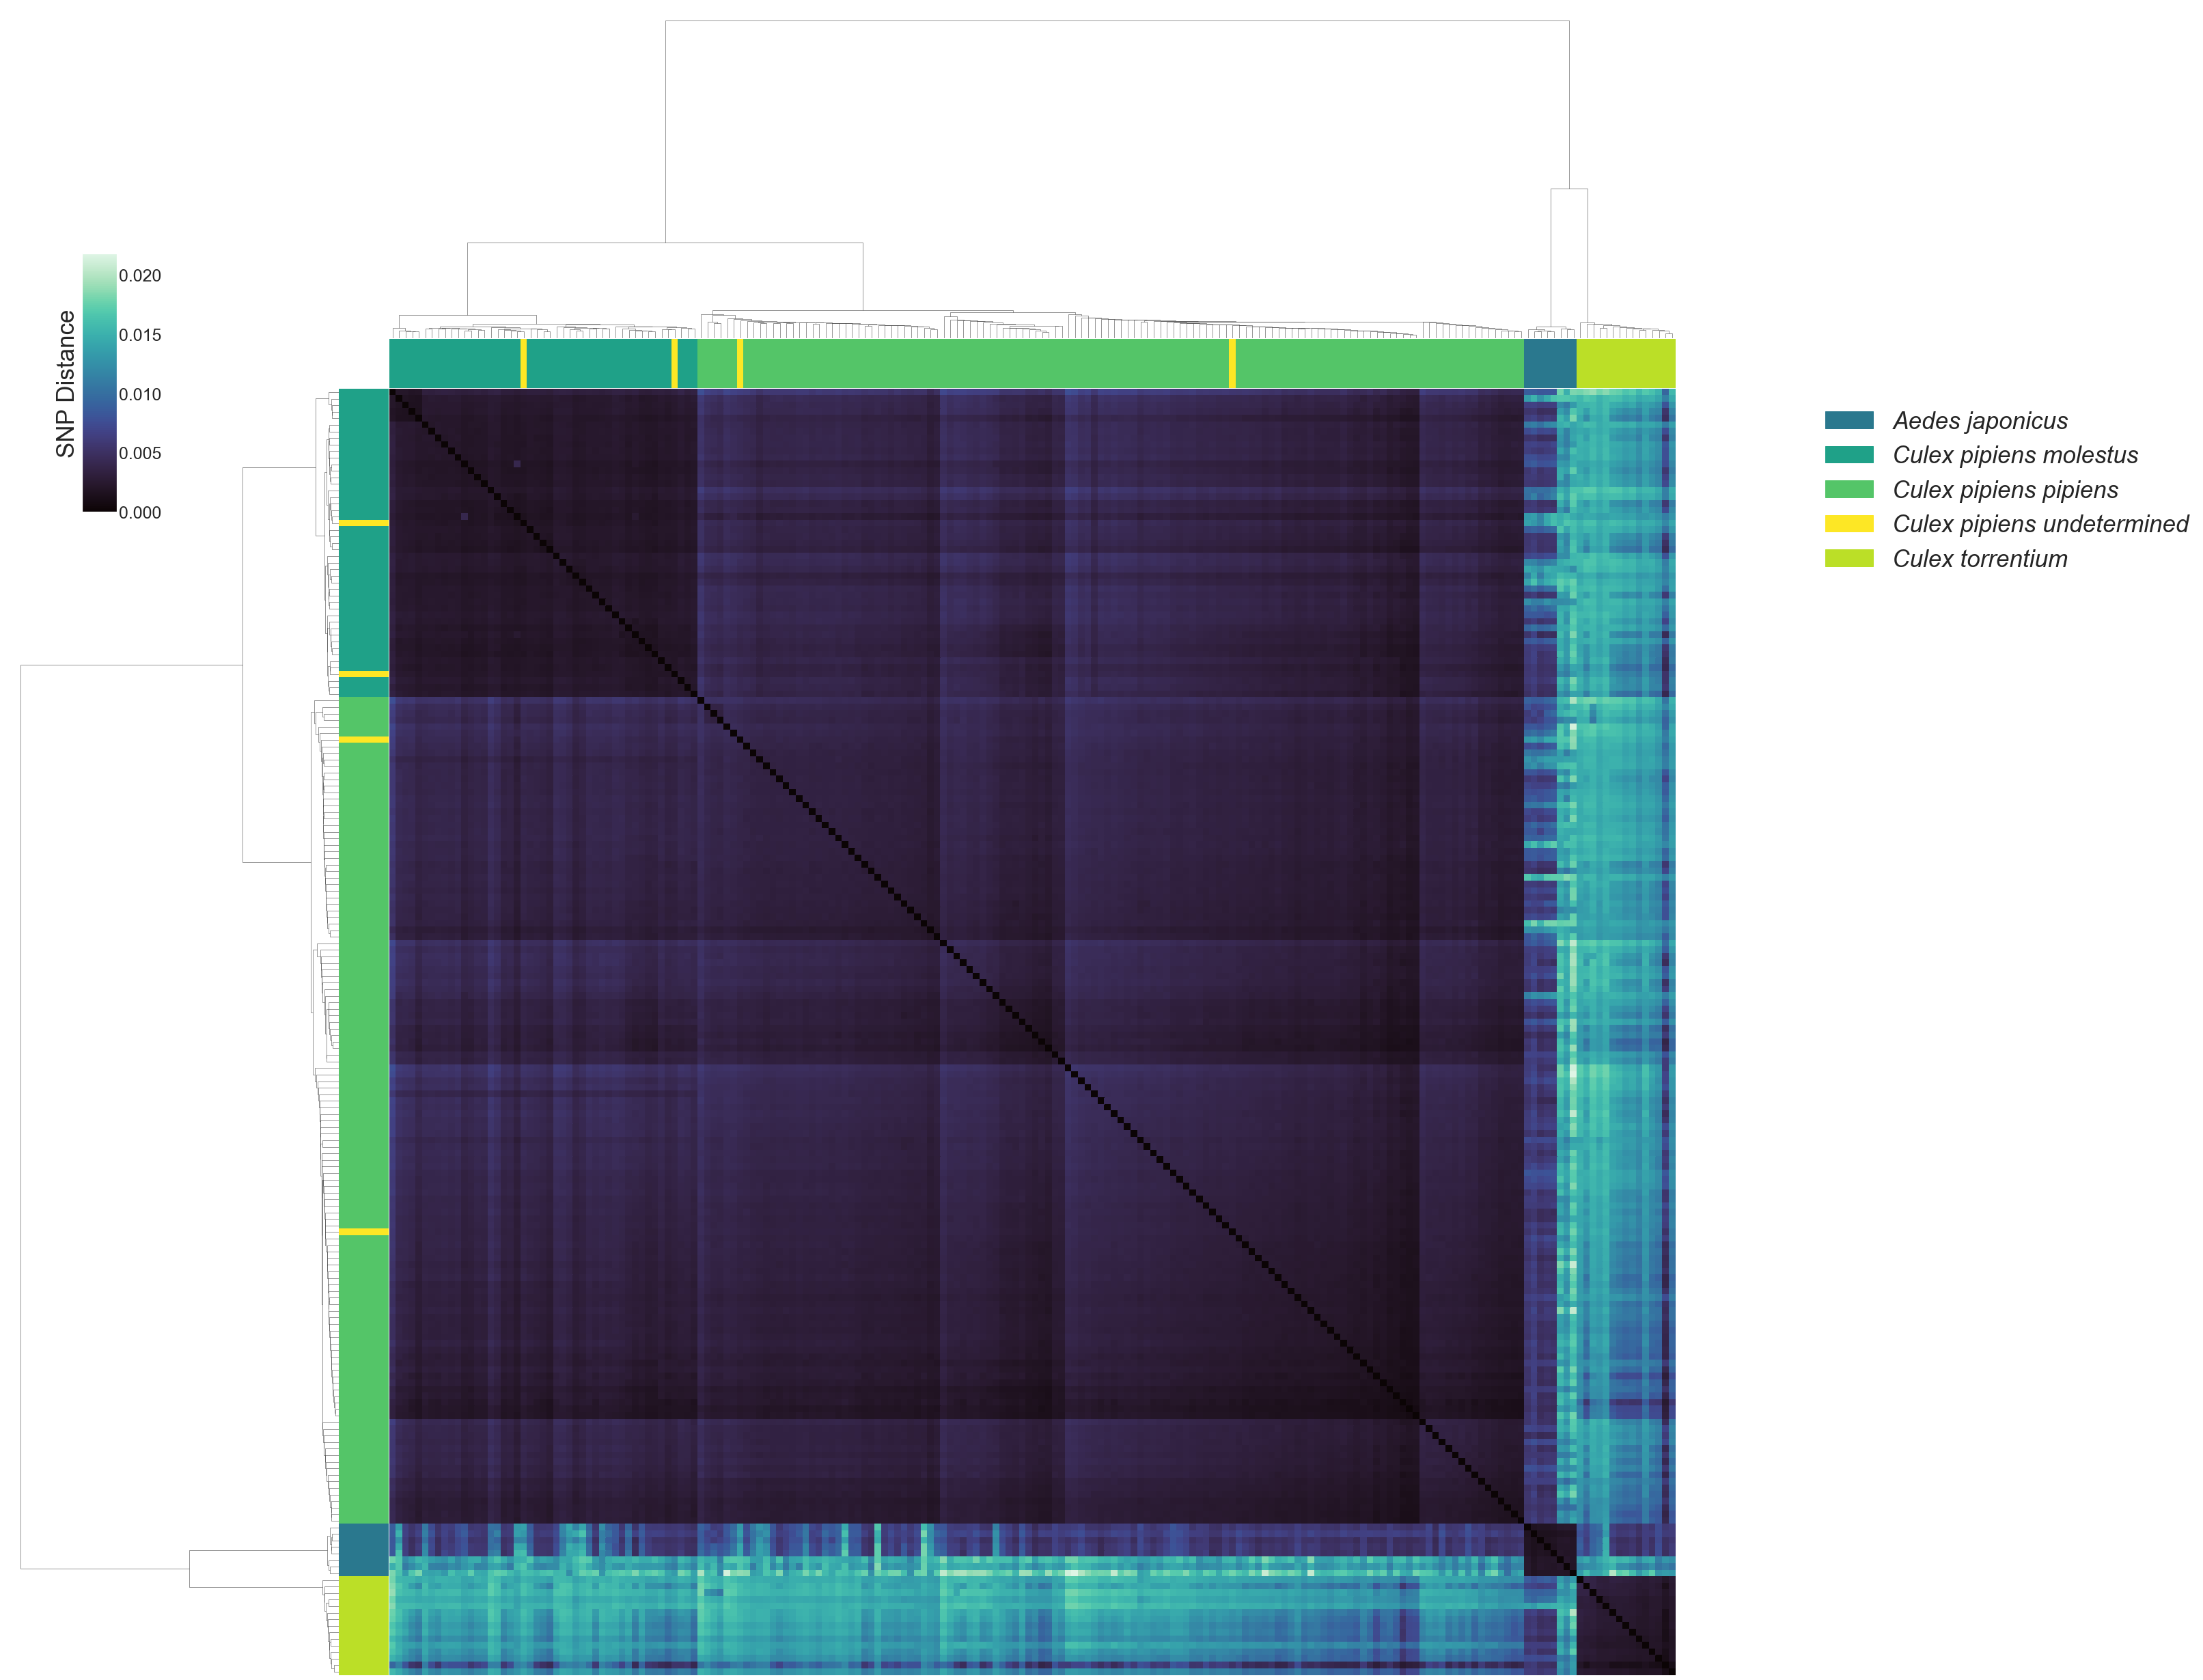

In [21]:
c, leg, cbar, final_pivot_w_labels = wrap_clustermap_and_mismatches(
    t_raw,
    species_id,
    k=4,
    figsize=(35,35),
    values="SNP_distance",
    diagonal=0,
    fontsize=35,
    labelsize=25
)

final_pivot_w_labels.query(
    'visual_species != ska_species'
)

Legend: Species relabeling by hierarchical clustering. Heatmap shows pairwise SNP distances between samples estimated using SKA, ranging from 0 (no SNPs detected, black) to 0.01 (1% of comparable sites had SNPs, blue). Outside colorbar indicates visual species label for each sample (Original), inside colorbar indicates consensus visual label for each sample's cluster (Corrected). Each sample was relabeled using it's cluster's consensus.

Text: Species relabeling was performed by clustering samples into genetically similar groups using SNP distances estimated from RNA-seq, and replacing the label for each sample with the most common label in its cluster. Hierarchical clustering based on the Ward distance was used (ref sklearn), and the number of clusters were chosen based on the number of distinct species present (n=10). SNP distances were calculated with SKA using a kmer-sized window of 15 (need reference here), run with nextflow (need reference here) on 100,000 reads subsampled from each mosquito's fastq file using seqtk (need reference here). This resulted in 8 samples having their species corrected.

In [19]:
c.savefig(
    "figures/species_assignment_clustermap.pdf",
    format="pdf",
    bbox_inches='tight',
    dpi=300
)